## 5.1. Source Localization

**Learning Objectives:**
- Understand the forward and inverse problems in EEG/MEG
- Learn how to compute forward models (lead field matrices)
- Apply different inverse solutions to localize brain activity
- Visualize source estimates on cortical surfaces
- Compare minimum norm estimation (MNE) with other methods
- Understand the limitations and assumptions of source localization

**Key Concepts:**
- **Forward Problem**: Given a source in the brain, predict the scalp signals
- **Inverse Problem**: Given scalp signals, estimate the underlying brain sources
- **Lead Field Matrix**: Maps source activity to sensor measurements
- **Inverse Solutions**: MNE, dSPM, sLORETA, beamformers
- **Source Space**: Discrete grid of possible source locations in the brain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import mne
from mne.datasets import sample
from mne.minimum_norm import (make_inverse_operator, apply_inverse, apply_inverse_epochs, write_inverse_operator)

from mne.viz import plot_sparse_source_estimates
mne.viz.set_3d_backend('notebook')

import warnings
warnings.filterwarnings('ignore')

Using notebook 3d backend.


### 1. Understanding Source Localization

#### The Forward and Inverse Problems

**The Forward Problem:**
- **Question**: If we know where neural activity originates, what signals would we measure at the sensors?
- **Solution**: Use physics (Maxwell's equations) to model how electrical currents propagate
- **Result**: The **lead field matrix** (or gain matrix)

**The Inverse Problem:**
- **Question**: Given sensor measurements, where in the brain did the activity originate?
- **Challenge**: This is **ill-posed** – infinitely many source configurations can produce the same sensor data
- **Solution**: Apply constraints and assumptions to find the most likely sources

#### Why is the Inverse Problem Ill-Posed?

Imagine you have:
- **60 EEG sensors** measuring voltages on the scalp
- **Thousands of possible source locations** in the brain

This means we have **more unknowns than measurements** – like trying to solve 60 equations with 5000 unknowns. We need additional assumptions to make the problem solvable.

#### Common Assumptions:
1. **Minimum energy**: Sources use minimal total energy (MNE)
2. **Spatial smoothness**: Nearby sources tend to be active together
3. **Sparsity**: Only a few sources are active at once (beamformers)

### 2. Source Localization Pipeline

The complete pipeline involves several steps:

1. **Prepare anatomical data** (MRI, BEM model)
2. **Compute forward solution** (lead field matrix)
3. **Create source space** (possible source locations)
4. **Compute noise covariance** (estimate sensor noise)
5. **Compute inverse operator** (combines forward model + noise)
6. **Apply inverse solution** to data

For this tutorial, we'll use the MNE sample dataset which includes all necessary anatomical information.

In [2]:
repo_root = Path("./").resolve().parents[1]
target_dir = repo_root / "datasets" / "meg_sample"
target_dir.mkdir(parents=True, exist_ok=True)

data_path = sample.data_path(path=str(target_dir), download=True)
subjects_dir = data_path / 'subjects'

# Load MEG data (better for source localization than EEG)
meg_file = data_path / "MEG" / "sample" / "sample_audvis_raw.fif"
events_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_raw-eve.fif'

raw = mne.io.read_raw_fif(meg_file, preload=True)
events = mne.read_events(events_fname)

print(f"Loaded raw data: {raw}")
print(f"Number of events: {len(events)}")

Opening raw data file /Users/yibeisita/Documents/neuro-ai-playground/datasets/meg_sample/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Loaded raw data: <Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~481.7 MiB, data loaded>
Number of events: 320


In [3]:
# Basic preprocessing
raw.filter(l_freq=1.0, h_freq=40.0, verbose=False)

# Pick MEG channels (gradiometers have better spatial resolution)
raw.pick_types(meg='grad', eeg=False, eog=True, stim=False)

print(f"Using {len(raw.ch_names)} gradiometer channels")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using 204 gradiometer channels
Sampling frequency: 600.614990234375 Hz


In [4]:
# Event dictionary
event_id = {'auditory/left': 1, 'auditory/right': 2}

# Create epochs
epochs = mne.Epochs(raw, events, event_id, 
                    tmin=-0.2, tmax=0.5,
                    baseline=(None, 0),
                    preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6),
                    verbose=False)

print(f"Created {len(epochs)} epochs")
print(f"Epoch duration: {epochs.tmax - epochs.tmin:.2f} seconds")

# Average to create evoked response
evoked = epochs.average()
print(f"\nEvoked response: {evoked}")

Created 116 epochs
Epoch duration: 0.70 seconds

Evoked response: <Evoked | '0.48 × auditory/left + 0.52 × auditory/right' (average, N=116), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 203 ch, ~3.7 MiB>


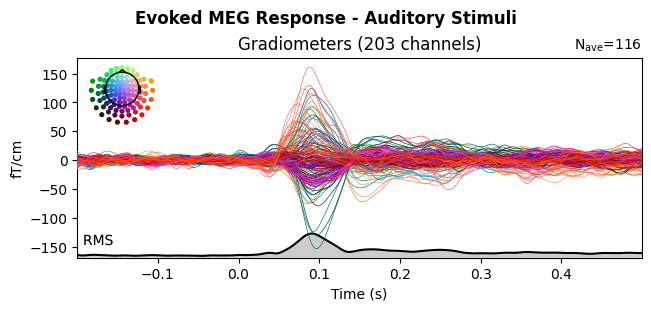

In [5]:
# Visualize evoked response
fig = evoked.plot(spatial_colors=True, gfp=True, show=False)
fig.suptitle('Evoked MEG Response - Auditory Stimuli', fontsize=12, fontweight='bold')

plt.show()

### 3. Setting Up Anatomical Information

For source localization, we need:

1. **BEM (Boundary Element Model)**: Models the head as layers (brain, skull, scalp)
2. **Source Space**: Grid of possible dipole locations (usually on the cortical surface)
3. **Transformation**: Alignment between MEG/EEG coordinates and MRI coordinates

The sample dataset includes pre-computed BEM and source space files.

In [6]:
# File paths for anatomical information
bem_fname = data_path / 'subjects' / 'sample' / 'bem' / 'sample-5120-bem-sol.fif'
src_fname = data_path / 'subjects' / 'sample' / 'bem' / 'sample-oct-6-src.fif'
trans_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_raw-trans.fif'

In [7]:
# Load BEM solution (boundary element model)
bem = mne.read_bem_solution(bem_fname)
print("BEM model loaded")
print(f"  Number of surfaces: {len(bem['surfs'])}")

Loading surfaces...

Loading the solution matrix...

Homogeneous model surface loaded.
Loaded linear collocation BEM solution from /Users/yibeisita/Documents/neuro-ai-playground/datasets/meg_sample/MNE-sample-data/subjects/sample/bem/sample-5120-bem-sol.fif
BEM model loaded
  Number of surfaces: 1


In [8]:
# Load source space
src = mne.read_source_spaces(src_fname)
print(f"\nSource space loaded")
print(f"  Number of source spaces: {len(src)}")
print(f"  Left hemisphere: {src[0]['nuse']} sources")
print(f"  Right hemisphere: {src[1]['nuse']} sources")
print(f"  Total sources: {src[0]['nuse'] + src[1]['nuse']}")

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read

Source space loaded
  Number of source spaces: 2
  Left hemisphere: 4098 sources
  Right hemisphere: 4098 sources
  Total sources: 8196


### 4. Visualizing the Source Space

The source space consists of dipoles positioned on the cortical surface. Let's visualize where these sources are located.

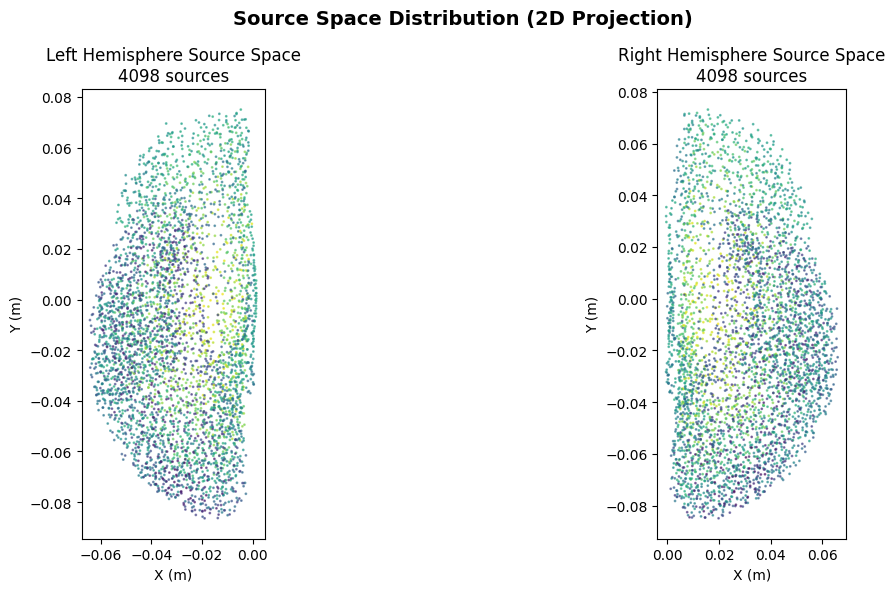

In [9]:
# Plot source space statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left hemisphere
ax = axes[0]
lh_points = src[0]['rr'][src[0]['vertno']]
ax.scatter(lh_points[:, 0], lh_points[:, 1], c=lh_points[:, 2], cmap='viridis', s=1, alpha=0.6)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title(f'Left Hemisphere Source Space\n{src[0]["nuse"]} sources')
ax.set_aspect('equal')

# Right hemisphere
ax = axes[1]
rh_points = src[1]['rr'][src[1]['vertno']]
ax.scatter(rh_points[:, 0], rh_points[:, 1], c=rh_points[:, 2], cmap='viridis', s=1, alpha=0.6)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title(f'Right Hemisphere Source Space\n{src[1]["nuse"]} sources')
ax.set_aspect('equal')

plt.suptitle('Source Space Distribution (2D Projection)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5. Computing the Forward Solution

The **forward solution** (also called the **lead field matrix** or **gain matrix**) describes how activity at each source location would appear at the sensors.

**Mathematical representation:**
$$M = G \cdot S + N$$

Where:
- $M$: Measured sensor data (channels × time)
- $G$: Lead field matrix (channels × sources)  
- $S$: Source activity (sources × time)
- $N$: Noise

**Dimensions example:**
- 204 MEG channels
- 7498 source locations  
- Lead field matrix: **204 × 7498**

Each column tells us: "If this one source were active, what would all sensors measure?"

In [10]:
fwd = mne.make_forward_solution(
    evoked.info,
    trans=trans_fname,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,  # Minimum distance from inner skull (mm)
    n_jobs=1,
    verbose=False
)

print("Forward solution computed")
print(f"  Channels: {fwd['nchan']}")
print(f"  Sources: {fwd['nsource']}")
print(f"  Lead field shape: {fwd['nchan']} × {fwd['nsource']}")
print(f"  Coordinate frame: {fwd['coord_frame']}")

Forward solution computed
  Channels: 203
  Sources: 7498
  Lead field shape: 203 × 7498
  Coordinate frame: 4 (FIFFV_COORD_HEAD)


Lead field matrix shape: (203, 22494)
  Each column represents one source
  Each row represents one sensor


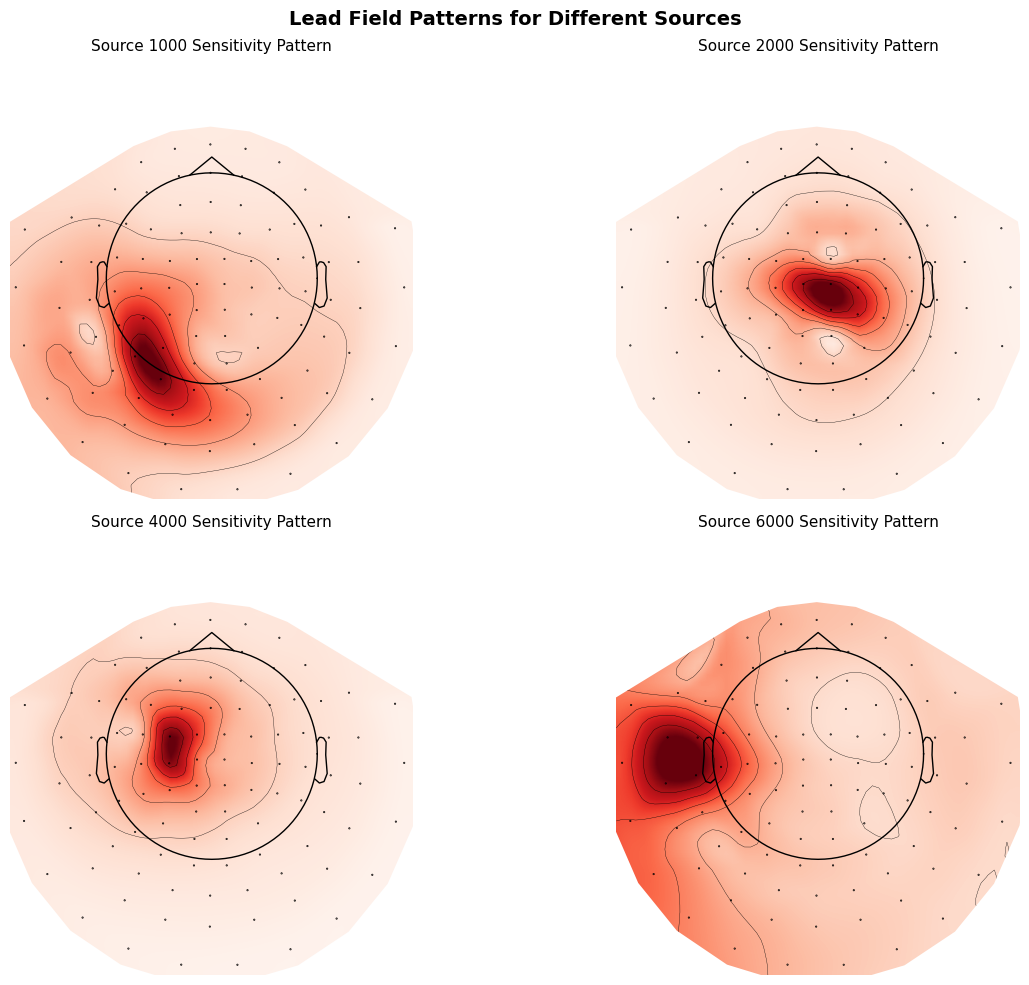

In [11]:
# Extract lead field matrix
leadfield = fwd['sol']['data']

print(f"Lead field matrix shape: {leadfield.shape}")
print(f"  Each column represents one source")
print(f"  Each row represents one sensor")

# Visualize a few columns (source sensitivities)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, source_idx in enumerate([1000, 2000, 4000, 6000]):
    # Get sensitivity pattern for this source
    pattern = leadfield[:, source_idx]
    
    # Create evoked object to plot topography
    evoked_pattern = mne.EvokedArray(
        pattern.reshape(-1, 1),
        evoked.info,
        tmin=0
    )
    
    evoked_pattern.plot_topomap(
        times=0,
        axes=axes[idx],
        show=False,
        colorbar=False,
        time_format=f'Source {source_idx}'
    )
    axes[idx].set_title(f'Source {source_idx} Sensitivity Pattern', fontsize=11)

plt.suptitle('Lead Field Patterns for Different Sources', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6. Estimating Noise Covariance

To solve the inverse problem optimally, we need to know the noise characteristics of our sensors.

**Why is this important?**
- Different sensors have different noise levels
- Sensors can have correlated noise
- We want to **weight** sensors inversely to their noise level
- Cleaner sensors should have more influence on the solution

We estimate noise from the **baseline period** (before stimulus onset).

In [12]:
# Compute noise covariance from baseline period
noise_cov = mne.compute_covariance(
    epochs,
    tmax=0.0,  # Use data before stimulus onset
    method='shrunk',  # Regularization method
    rank=None,
    verbose=False
)

print("Noise covariance computed")
print(f"  Method: {noise_cov['method']}")
print(f"  Number of samples: {noise_cov['nfree']}")

Noise covariance computed
  Method: shrunk
  Number of samples: 14035


Computing rank from covariance with rank=None
    Using tolerance 1.9e-13 (2.2e-16 eps * 203 dim * 4.1  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors


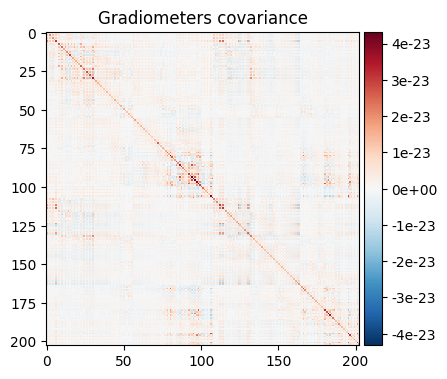

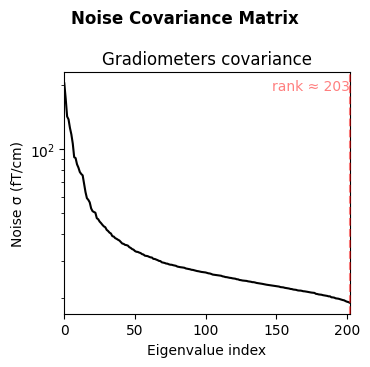

In [13]:
# Visualize noise covariance
fig = mne.viz.plot_cov(noise_cov, evoked.info, show=False)
plt.suptitle('Noise Covariance Matrix', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### 7. Creating the Inverse Operator

The **inverse operator** combines:
1. Forward solution (how sources → sensors)
2. Noise covariance (sensor noise characteristics)  
3. Regularization parameter (λ, controls smoothness)

This creates a matrix that maps from sensors back to sources.

**Types of inverse solutions:**
- **MNE (Minimum Norm Estimate)**: Minimum energy solution
- **dSPM (dynamic SPM)**: MNE normalized by noise sensitivity
- **sLORETA**: Zero localization error in noise-free case
- **eLORETA**: Exact low-resolution tomography

In [14]:
# Create inverse operator
inverse_operator = make_inverse_operator(
    evoked.info,
    fwd,
    noise_cov,
    loose=0.2,  # Allow sources to have component perpendicular to cortex
    depth=0.8,  # Depth weighting to compensate for depth bias
    verbose=False
)

print("Inverse operator created")
print(f"  Source orientation constraint: {inverse_operator['source_ori']}")
print(f"  Loose orientation: {inverse_operator['orient_prior']['data'][0]}")

Inverse operator created
  Source orientation constraint: 2 (FIFFV_MNE_FREE_ORI)
  Loose orientation: 0.2


### 8. Applying the Inverse Solution

Now we can finally estimate where the brain activity originated!

We'll apply different inverse methods and compare them:
- **MNE**: Minimum overall source energy
- **dSPM**: MNE normalized by source variance (better for comparing across locations)
- **sLORETA**: Zero localization error under ideal conditions

In [15]:
# Apply minimum norm estimate
snr = 3.0  # Signal-to-noise ratio
lambda2 = 1.0 / snr ** 2  # Regularization parameter

# Compute source estimate using different methods
methods = ['MNE', 'dSPM', 'sLORETA']
stcs = {}

for method in methods:
    stcs[method] = apply_inverse(
        evoked,
        inverse_operator,
        lambda2,
        method=method,
        pick_ori=None,
        verbose=False
    )
    print(f"{method} source estimate computed")
    print(f"  Shape: {stcs[method].data.shape} (sources × time)")
    print(f"  Time points: {len(stcs[method].times)}")

MNE source estimate computed
  Shape: (7498, 421) (sources × time)
  Time points: 421
dSPM source estimate computed
  Shape: (7498, 421) (sources × time)
  Time points: 421
sLORETA source estimate computed
  Shape: (7498, 421) (sources × time)
  Time points: 421


### 9. Visualizing Source Activity on the Brain

Let's visualize the estimated source activity on the cortical surface at the peak of the auditory response (~100 ms).

In [16]:
# Find peak time in the evoked response
peak_time = evoked.get_peak()[1]
peak_time_idx = np.argmin(np.abs(stcs['dSPM'].times - peak_time))
print(f"Peak response at {peak_time*1000:.1f} ms")
print(f"Peak time index at {peak_time_idx}")

Peak response at 88.2 ms
Peak time index at 173


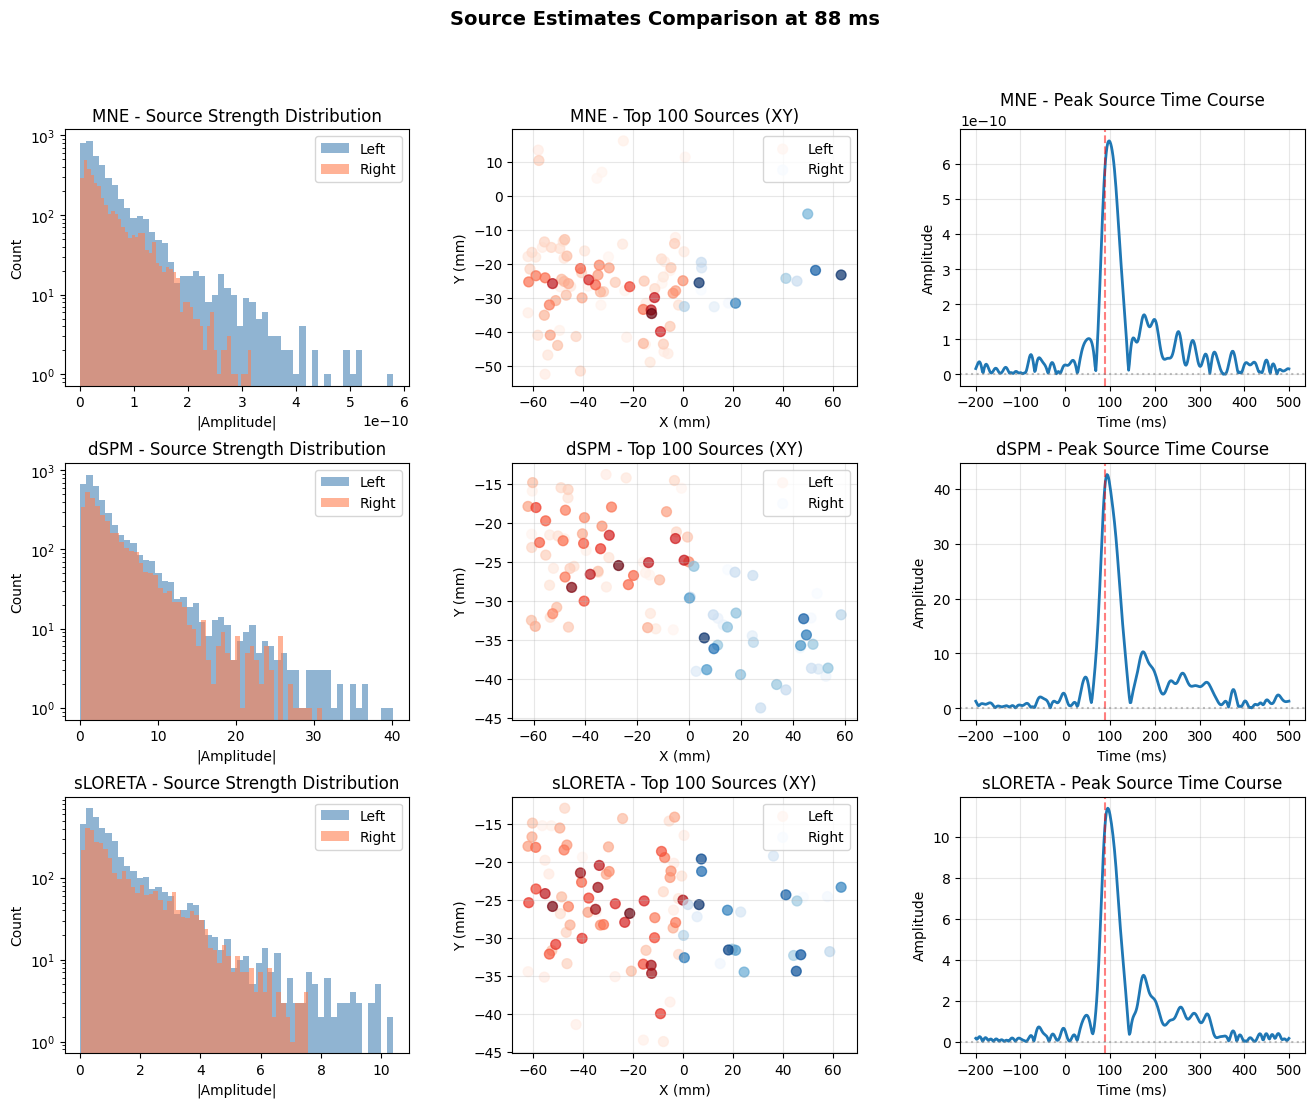

In [17]:
# Plot source estimates for each method
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

for idx, method in enumerate(methods):
    stc = stcs[method]
    
    # Get data at peak time
    data = stc.data[:, peak_time_idx]
    
    # Separate hemispheres
    lh_data = data[:src[0]['nuse']]
    rh_data = data[src[0]['nuse']:]
    
    # Plot histogram of source strengths
    ax = fig.add_subplot(gs[idx, 0])
    ax.hist(np.abs(lh_data), bins=50, alpha=0.6, label='Left', color='steelblue')
    ax.hist(np.abs(rh_data), bins=50, alpha=0.6, label='Right', color='coral')
    ax.set_xlabel('|Amplitude|')
    ax.set_ylabel('Count')
    ax.set_title(f'{method} - Source Strength Distribution')
    ax.legend()
    ax.set_yscale('log')
    
    # Plot top 100 sources in space
    n_top = 100
    top_indices = np.argsort(np.abs(data))[-n_top:]
    
    # Determine which hemisphere each top source belongs to
    lh_mask = top_indices < src[0]['nuse']
    rh_mask = ~lh_mask
    
    lh_indices = top_indices[lh_mask]
    rh_indices = top_indices[rh_mask] - src[0]['nuse']
    
    # XY projection
    ax = fig.add_subplot(gs[idx, 1])
    if len(lh_indices) > 0:
        lh_pos = src[0]['rr'][src[0]['vertno'][lh_indices]]
        ax.scatter(lh_pos[:, 0]*1000, lh_pos[:, 1]*1000,
                  c=np.abs(lh_data[lh_indices]), cmap='Reds',
                  s=50, alpha=0.7, label='Left')
    if len(rh_indices) > 0:
        rh_pos = src[1]['rr'][src[1]['vertno'][rh_indices]]
        ax.scatter(rh_pos[:, 0]*1000, rh_pos[:, 1]*1000,
                  c=np.abs(rh_data[rh_indices]), cmap='Blues',
                  s=50, alpha=0.7, label='Right')
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(f'{method} - Top {n_top} Sources (XY)')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Time course of strongest source
    peak_source = np.argmax(np.abs(data))
    ax = fig.add_subplot(gs[idx, 2])
    ax.plot(stc.times * 1000, stc.data[peak_source, :], linewidth=2)
    ax.axvline(peak_time * 1000, color='red', linestyle='--', alpha=0.5)
    ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'{method} - Peak Source Time Course')
    ax.grid(alpha=0.3)

plt.suptitle(f'Source Estimates Comparison at {peak_time*1000:.0f} ms', 
             fontsize=14, fontweight='bold')
plt.show()

### 10. Extracting Source Time Courses

We can extract the time course of activity from specific brain regions to see how source activity evolves over time.

In [18]:
# Find the vertex (source) with maximum activity
method = 'dSPM'  # Use dSPM for this analysis
stc = stcs[method]

# Define time window of interest
time_mask = (stc.times >= 0.08) & (stc.times <= 0.12)
time_window_data = stc.data[:, time_mask]

# Find peak directly from the data array
peak_source_idx = np.unravel_index(
    np.argmax(np.abs(time_window_data)), 
    time_window_data.shape
)[0]

# Find peak time index in the windowed data
peak_time_idx_window = np.unravel_index(
    np.argmax(np.abs(time_window_data)), 
    time_window_data.shape
)[1]

# Convert to full time index
time_indices = np.where(time_mask)[0]
peak_time_idx = time_indices[peak_time_idx_window]
peak_time_val = stc.times[peak_time_idx]

# Determine hemisphere
n_lh_sources = src[0]['nuse']
hemisphere = 'Left' if peak_source_idx < n_lh_sources else 'Right'

print("=" * 60)
print("PEAK SOURCE INFORMATION")
print("=" * 60)
print(f"Peak source index: {peak_source_idx}")
print(f"Peak time: {peak_time_val*1000:.2f} ms")
print(f"Peak time index: {peak_time_idx}")
print(f"Peak amplitude: {stc.data[peak_source_idx, peak_time_idx]:.3f} dSPM units")
print(f"Hemisphere: {hemisphere}")
print(f"Search window: 80-120 ms")
print("=" * 60)

PEAK SOURCE INFORMATION
Peak source index: 1519
Peak time: 94.90 ms
Peak time index: 177
Peak amplitude: 42.861 dSPM units
Hemisphere: Left
Search window: 80-120 ms


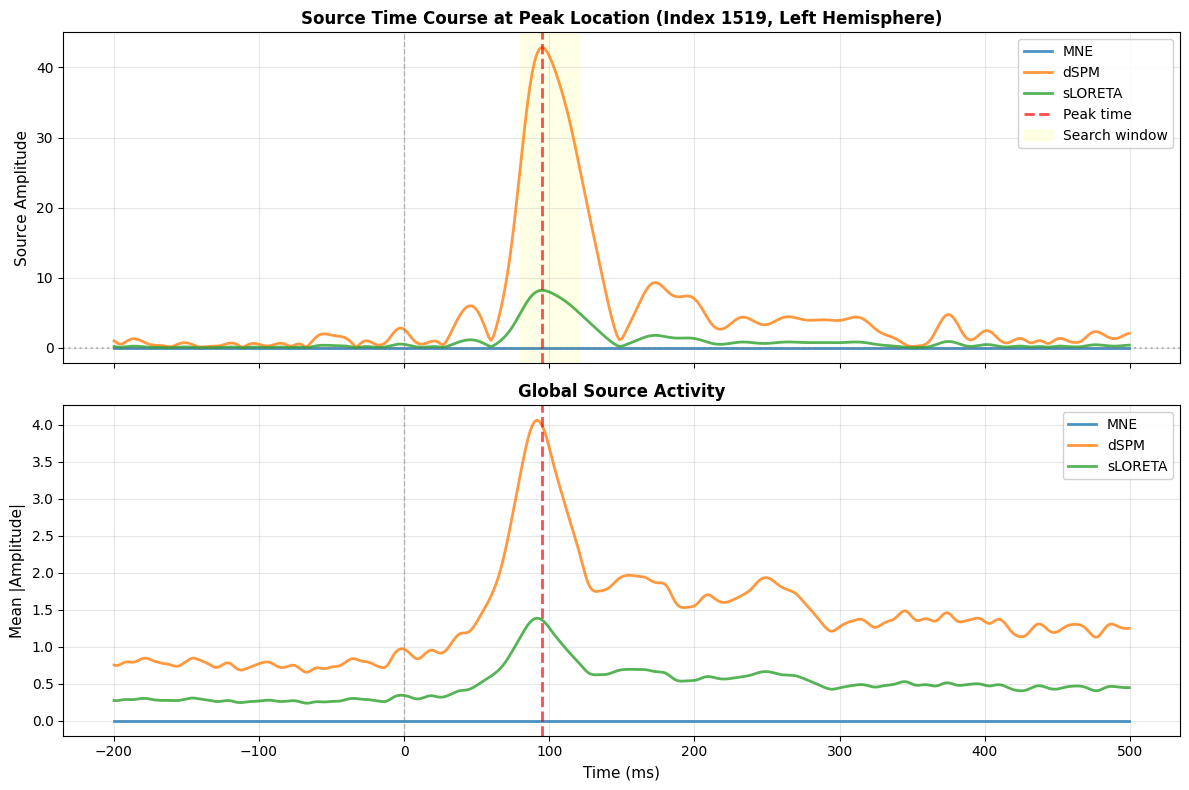

In [19]:
# Plot time course at peak location
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Compare methods at peak source
for method_name in methods:
    time_course = stcs[method_name].data[peak_source_idx, :]
    axes[0].plot(stcs[method_name].times * 1000, time_course, 
                 label=method_name, linewidth=2, alpha=0.8)

axes[0].axvline(peak_time_val * 1000, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Peak time')
axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
axes[0].axhline(0, color='gray', linestyle=':', alpha=0.5)
axes[0].axvspan(80, 120, alpha=0.1, color='yellow', label='Search window')
axes[0].set_ylabel('Source Amplitude', fontsize=11)
axes[0].set_title(f'Source Time Course at Peak Location (Index {peak_source_idx}, {hemisphere} Hemisphere)', fontsize=12, fontweight='bold')
axes[0].legend(loc='best', framealpha=0.9)
axes[0].grid(alpha=0.3)

# Plot spatial extent over time (mean activity across all sources)
for method_name in methods:
    mean_activity = np.mean(np.abs(stcs[method_name].data), axis=0)
    axes[1].plot(stcs[method_name].times * 1000, mean_activity, label=method_name, linewidth=2, alpha=0.8)

axes[1].axvline(peak_time_val * 1000, color='red', linestyle='--', alpha=0.7, linewidth=2)
axes[1].axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
axes[1].set_xlabel('Time (ms)', fontsize=11)
axes[1].set_ylabel('Mean |Amplitude|', fontsize=11)
axes[1].set_title('Global Source Activity', fontsize=12, fontweight='bold')
axes[1].legend(loc='best', framealpha=0.9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 11. Region of Interest (ROI) Analysis

Instead of looking at individual vertices, we can use anatomical **labels** (parcellation) to extract activity from specific brain regions.

The FreeSurfer segmentation provides anatomical labels like:
- Primary auditory cortex
- Visual cortex  
- Motor cortex
- etc.

In [20]:
# Load labels for auditory cortex
label_name = 'auditory-lh'
label = mne.read_labels_from_annot(
    'sample', 
    parc='aparc', 
    subjects_dir=subjects_dir,
    regexp='transversetemporal'  # Primary auditory cortex
)[0]

print(f"Loaded label: {label.name}")
print(f"  Hemisphere: {label.hemi}")
print(f"  Number of vertices: {len(label.vertices)}")

Reading labels from parcellation...
   read 1 labels from /Users/yibeisita/Documents/neuro-ai-playground/datasets/meg_sample/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 1 labels from /Users/yibeisita/Documents/neuro-ai-playground/datasets/meg_sample/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Loaded label: transversetemporal-lh
  Hemisphere: lh
  Number of vertices: 770


In [21]:
# Extract time course from this label
stc_label = stc.in_label(label)
mean_tc = np.mean(stc_label.data, axis=0)

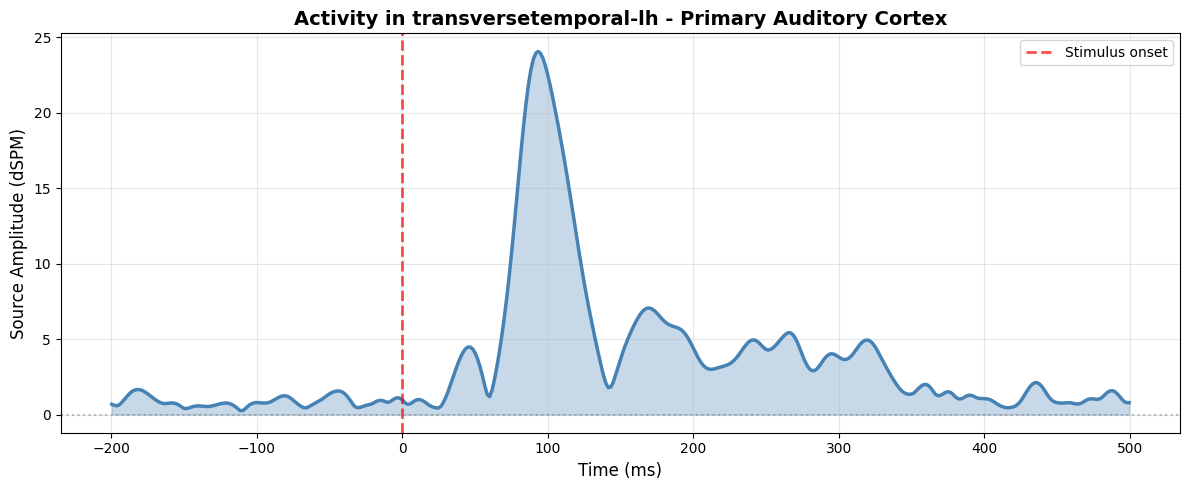

In [22]:
# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(stc.times * 1000, mean_tc, linewidth=2.5, color='steelblue')
ax.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Stimulus onset')
ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.fill_between(stc.times * 1000, 0, mean_tc, alpha=0.3, color='steelblue')
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Source Amplitude (dSPM)', fontsize=12)
ax.set_title(f'Activity in {label.name} - Primary Auditory Cortex', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 12. Hemispheric Lateralization

Let's compare source activity for left vs. right ear auditory stimulation to see if we can detect lateralized responses.

In [23]:
# Create separate evoked responses
evoked_left = epochs['auditory/left'].average()
evoked_right = epochs['auditory/right'].average()

# Compute source estimates
stc_left = apply_inverse(evoked_left, inverse_operator, lambda2, method='dSPM', verbose=False)
stc_right = apply_inverse(evoked_right, inverse_operator, lambda2, method='dSPM', verbose=False)

# Compute difference
stc_diff = stc_left - stc_right

print("Source estimates computed for left and right stimulation")

Source estimates computed for left and right stimulation


In [24]:
# Find peak time
if 'peak_time_val' not in locals():
    peak_time_val = evoked.get_peak()[1]

peak_time_idx = np.argmin(np.abs(stc_left.times - peak_time_val))
n_lh = src[0]['nuse']

print(f"HEMISPHERIC LATERALIZATION ANALYSIS at {peak_time_val*1000:.1f} ms")

HEMISPHERIC LATERALIZATION ANALYSIS at 94.9 ms


In [25]:
# Analyze at peak time
for condition, stc in [('Left Ear', stc_left), ('Right Ear', stc_right), ('Difference', stc_diff)]:
    data = stc.data[:, peak_time_idx]
    lh_data = data[:n_lh]
    rh_data = data[n_lh:]
    
    print(f"\n{condition} Stimulation:")
    print(f"  Left Hemisphere:  mean={lh_data.mean():.3f}, max={lh_data.max():.3f}")
    print(f"  Right Hemisphere: mean={rh_data.mean():.3f}, max={rh_data.max():.3f}")
    print(f"  Lateralization Index: {(lh_data.mean() - rh_data.mean())/(lh_data.mean() + rh_data.mean()):.3f}")


Left Ear Stimulation:
  Left Hemisphere:  mean=2.789, max=28.920
  Right Hemisphere: mean=2.826, max=21.238
  Lateralization Index: -0.007

Right Ear Stimulation:
  Left Hemisphere:  mean=3.258, max=31.659
  Right Hemisphere: mean=2.859, max=20.680
  Lateralization Index: 0.065

Difference Stimulation:
  Left Hemisphere:  mean=-0.469, max=4.565
  Right Hemisphere: mean=-0.033, max=6.068
  Lateralization Index: 0.869


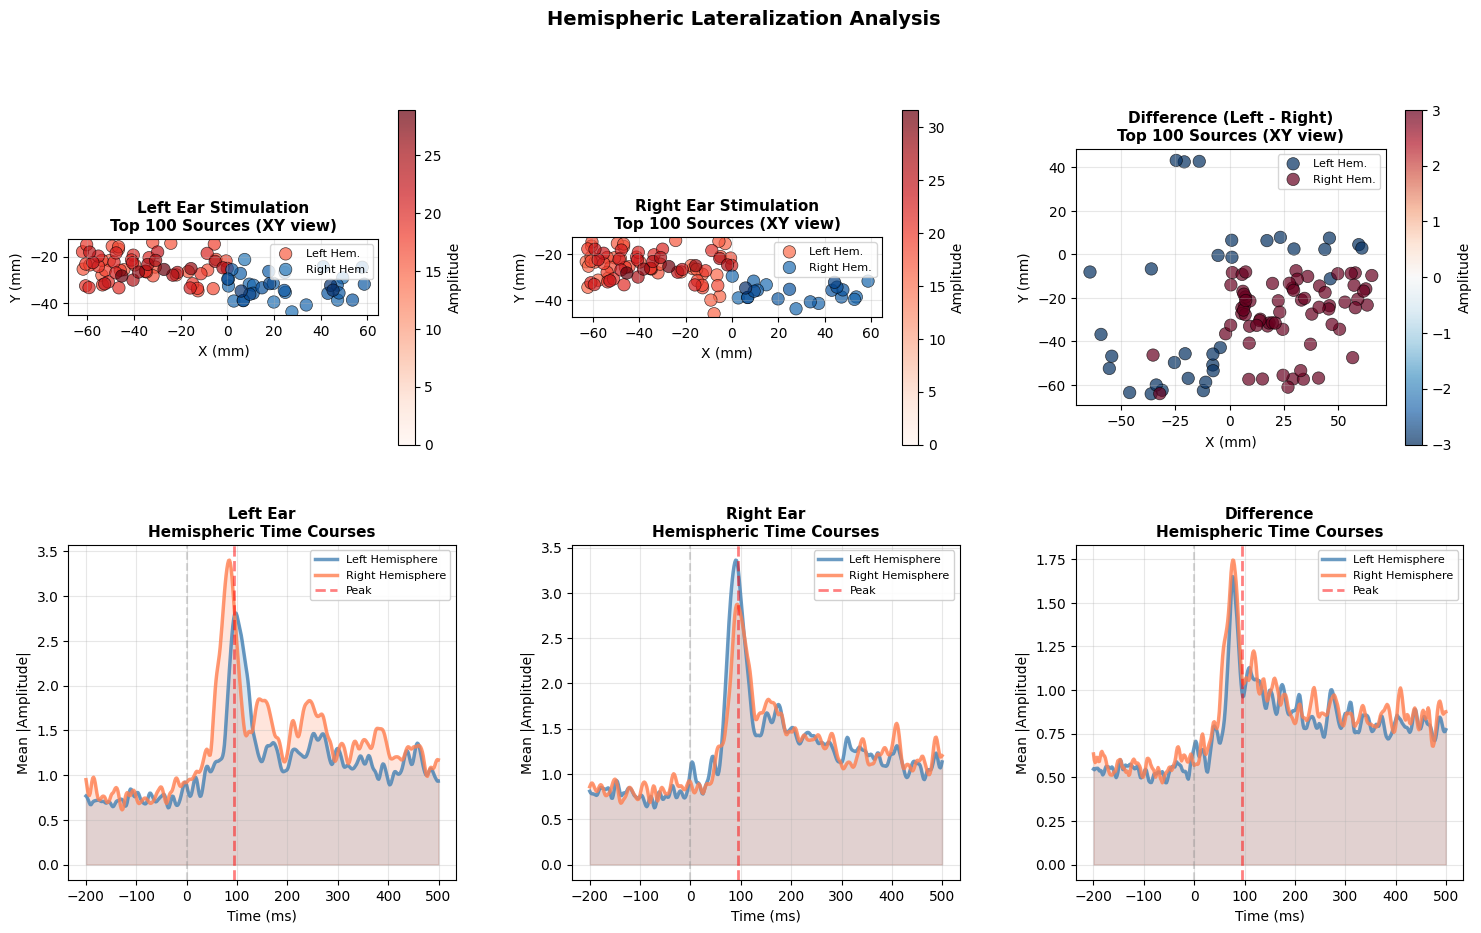

In [26]:
# Hemispheric comparison
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Top row: Spatial distribution at peak time
for col, (stc, title) in enumerate([
    (stc_left, 'Left Ear Stimulation'),
    (stc_right, 'Right Ear Stimulation'),
    (stc_diff, 'Difference (Left - Right)')
]):
    ax = fig.add_subplot(gs[0, col])
    
    data = stc.data[:, peak_time_idx]
    
    # Get top 100 sources
    top_n = 100
    top_indices = np.argsort(np.abs(data))[-top_n:]
    
    # Separate by hemisphere
    lh_mask = top_indices < n_lh
    rh_mask = ~lh_mask
    
    lh_indices = top_indices[lh_mask]
    rh_indices = top_indices[rh_mask] - n_lh
    
    # Plot source positions (XY projection)
    if len(lh_indices) > 0:
        lh_pos = src[0]['rr'][src[0]['vertno'][lh_indices]]
        scatter_lh = ax.scatter(lh_pos[:, 0]*1000, lh_pos[:, 1]*1000,
                   c=data[lh_indices], cmap='Reds' if col != 2 else 'RdBu_r',
                   s=80, alpha=0.7, edgecolor='black', linewidth=0.5,
                   label='Left Hem.', vmin=-3 if col == 2 else 0, 
                   vmax=3 if col == 2 else None)
    
    if len(rh_indices) > 0:
        rh_pos = src[1]['rr'][src[1]['vertno'][rh_indices]]
        scatter_rh = ax.scatter(rh_pos[:, 0]*1000, rh_pos[:, 1]*1000,
                   c=data[n_lh + rh_indices], cmap='Blues' if col != 2 else 'RdBu_r',
                   s=80, alpha=0.7, edgecolor='black', linewidth=0.5,
                   label='Right Hem.', vmin=-3 if col == 2 else 0,
                   vmax=3 if col == 2 else None)
    
    ax.set_xlabel('X (mm)', fontsize=10)
    ax.set_ylabel('Y (mm)', fontsize=10)
    ax.set_title(f'{title}\nTop {top_n} Sources (XY view)', fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')
    
    # Add colorbar
    if len(lh_indices) > 0 or len(rh_indices) > 0:
        plt.colorbar(scatter_lh if len(lh_indices) > 0 else scatter_rh, 
                    ax=ax, label='Amplitude')

# Bottom row: Time course analysis
for col, (stc, title, color) in enumerate([
    (stc_left, 'Left Ear', 'red'),
    (stc_right, 'Right Ear', 'blue'),
    (stc_diff, 'Difference', 'green')
]):
    ax = fig.add_subplot(gs[1, col])
    
    # Compute mean activity per hemisphere over time
    lh_mean = np.mean(np.abs(stc.data[:n_lh, :]), axis=0)
    rh_mean = np.mean(np.abs(stc.data[n_lh:, :]), axis=0)
    
    ax.plot(stc.times * 1000, lh_mean, 
            label='Left Hemisphere', linewidth=2.5, 
            color='steelblue', alpha=0.8)
    ax.plot(stc.times * 1000, rh_mean, 
            label='Right Hemisphere', linewidth=2.5, 
            color='coral', alpha=0.8)
    
    ax.axvline(peak_time_val * 1000, color='red', 
               linestyle='--', alpha=0.5, linewidth=2, label='Peak')
    ax.axvline(0, color='gray', linestyle='--', alpha=0.3, linewidth=1.5)
    ax.fill_between(stc.times * 1000, lh_mean, alpha=0.2, color='steelblue')
    ax.fill_between(stc.times * 1000, rh_mean, alpha=0.2, color='coral')
    
    ax.set_xlabel('Time (ms)', fontsize=10)
    ax.set_ylabel('Mean |Amplitude|', fontsize=10)
    ax.set_title(f'{title}\nHemispheric Time Courses', fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=8, framealpha=0.9)
    ax.grid(alpha=0.3)

plt.suptitle('Hemispheric Lateralization Analysis', fontsize=14, fontweight='bold')
plt.show()

## Summary and Key Takeaways

### What We Learned

1. **The Inverse Problem:**
   - Estimating brain sources from scalp measurements is ill-posed
   - Requires assumptions and constraints (minimum energy, smoothness, etc.)
   - Different methods make different assumptions

2. **Source Localization Pipeline:**
   ```
      Anatomical Info → Forward Model → Inverse Operator → Source Estimate
   ```

3. **Key Components:**
   - **BEM**: Models head geometry
   - **Source Space**: Possible source locations (cortical surface)
   - **Lead Field**: Maps sources to sensors
   - **Noise Covariance**: Characterizes sensor noise
   - **Inverse Operator**: Combines all information to estimate sources

4. **Inverse Methods Compared:**
   - **MNE**: Minimum energy, tends to be spatially smooth
   - **dSPM**: Better for comparing across locations (normalized)
   - **sLORETA**: Zero localization error in ideal conditions
   - Each method has trade-offs between localization accuracy and spatial extent

5. **Applications:**
   - Localizing evoked responses
   - Extracting ROI time courses
   - Comparing conditions (left vs right stimulation)
   - Finding peak activations

### Limitations and Considerations

**Important Caveats:**
- Source localization is **always an estimate** (ill-posed problem)
- Spatial resolution is limited (~1-2 cm for EEG, better for MEG)
- Deep sources are harder to localize than superficial sources
- Results depend heavily on:
  - Head model accuracy
  - Co-registration quality
  - Regularization parameters
  - Choice of inverse method

### Best Practices

**Recommendations:**
- Always check your forward model and alignment
- Use appropriate regularization (SNR estimate)
- Compare multiple inverse methods
- Focus on ROI analysis rather than individual vertices
- Consider anatomical constraints when available
- Report method details and parameters for reproducibility